In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch

import gait
import utils

from sklearn.cluster import MiniBatchKMeans

### Importing data

In [10]:
df = pd.read_csv("./data/france/pop_fr_geoloc_1975_2010.csv")
X = np.array([df.long.values, df.lat.values]).T

# We normalize the data for a scale around -1 to 1 for better behavior in gradient descent
tX = torch.tensor([X[:, 0] / 10,  X[:, 1] / 50]).transpose(0, 1)

# Proportions according to population
np_fix_mu = (df.pop_2010.values[None, :] / df.pop_2010.values.sum()).squeeze()
fix_mu = torch.tensor(df.pop_2010.values[None, :] / df.pop_2010.values.sum())

# Points for approximating measure
n = 30

# Sample initialization. Will be used for both methods 
rix = np.random.choice(len(np_fix_mu), n, p=np_fix_mu / np_fix_mu.sum())
initX = X[rix, :]

### Run K-Means in minibatch setting 

In [11]:
%time kmeans = MiniBatchKMeans(n_clusters=n, random_state=0, init=initX).fit(X)

# Make assignments from real points to nearest neighbor in approximation
pp = np.zeros((len(X), kmeans.n_clusters))
pp[range(len(X)), kmeans.labels_] = 1
pops = df.pop_2010.values[:, None] / df.pop_2010.values.sum()
aa = (pp * pops).sum(0)

C:\Users\jgall\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Explicit initial center position passed: performing only one init in MiniBatchKMeans instead of n_init=3
  """Entry point for launching an IPython kernel.


Wall time: 230 ms


### Run clustering with proposed loss

In [12]:
d = 2
batch_size = n

mu = torch.tensor(np.array(batch_size * [1/batch_size])[None, :])
nu = torch.tensor(np.array(n * [1/n])[None, :])

rix = np.random.choice(len(np_fix_mu), n, p=np_fix_mu / np_fix_mu.sum())
tinitX = torch.tensor(np.concatenate([initX[:, 0:1] / 10,  initX[:, 1:2] / 50], axis=1))
Y = torch.nn.Parameter(tinitX)

y_optimizer = torch.optim.Adam([Y], lr=1e-3, betas=(0.99, 0.99), amsgrad=True)
optims = [y_optimizer]
loss_list = []

kernel = lambda x, y: gait.generic_kernel(x, y, lambda u, v: gait.rbf_kernel(u, v, sigmas=[0.02], log=False))
D = lambda x, y: gait.breg_mixture_divergence(mu, x, nu, y,  kernel)

In [13]:
for _ in range(3000):
    
    [_.zero_grad() for _ in optims]
    
    rix = np.random.choice(len(np_fix_mu), batch_size, p=np_fix_mu)
    cX = tX[rix]
    loss = D(cX, Y) 
    
    if _ % 250 == 0:
        print("%d - %.4f" % (_, loss.item()))

    loss.backward()
    [_.step() for _ in optims]


dists = utils.batch_pdist(Y, tX) 
pp = np.zeros((len(X), n))
pp[range(len(X)), torch.argmin(dists, dim=0).data.numpy()] = 1
pops = df.pop_2010.values[:, None] / df.pop_2010.values.sum()
bb = (pp * pops).sum(0)

0 - 5.3523
250 - 2.4586
500 - 3.9450
750 - 3.9250
1000 - 3.8569
1250 - 2.1301
1500 - 3.5304
1750 - 5.1905
2000 - 2.7939
2250 - 3.3717
2500 - 2.5263
2750 - 2.2076


### Plot comparison

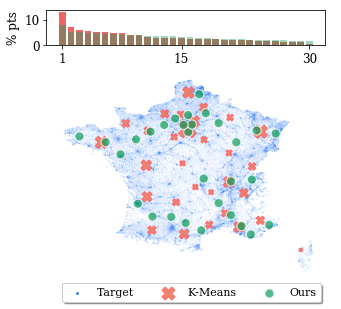

In [14]:
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 12

# Two subplots, unpack the axes array immediately
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5), gridspec_kw={'height_ratios': [1, 6]})

ax1.bar(range(1, n+1), -100*np.sort(-aa), color=(238/255,100/255,98/255), alpha=0.99, align='center')
ax1.bar(range(1, n+1), -100*np.sort(-bb), color=(15/255,157/255,88/255), alpha=0.4, align='center')
ax1.set_ylabel('% pts')
ax1.set_xticks([1, n/2, n])

ax2.scatter(tX.data.numpy()[:, 0], tX.data.numpy()[:, 1], s=list(1000*fix_mu.data.squeeze().numpy()), label='Target', marker='.', facecolors=(66/255, 134/255, 244/255), alpha=0.9)
ax2.scatter(kmeans.cluster_centers_[:, 0]/10, kmeans.cluster_centers_[:, 1]/50, s=2500*aa, label='K-Means', marker='X', alpha=0.9, edgecolors=(255/255,100/255,98/255), facecolors=(238/255,119/255,98/255), linewidths=0.99);
ax2.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(2500*nu.data.squeeze().numpy()), label='Ours', marker='o', facecolors=(15/255,157/255,88/255), edgecolors="w", linewidths=1.2, alpha=0.7)
plt.legend(loc='upper center', bbox_to_anchor=(0.52, 0.02), markerscale=None, fancybox=True, shadow=True, ncol=3, fontsize=11)
ax2.axis('off')

plt.subplots_adjust(hspace=0.2)

#plt.savefig('france_data_model', dpi=300)